<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_12/s12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download our code repository and install python dependencies

In [13]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git pull
!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"
!pip install --quiet "prettytable"
!pip install --quiet "torch_lr_finder"
!pip install --quiet "grad-cam"

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
fatal: destination path 'dl_hub' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports:

In [18]:
from __future__ import print_function
import os
import sys
from typing import Any
sys.path.append("../dl_hub")
sys.path.append("../ERA_V1/session_12")
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from pytorch_lightning import seed_everything
from dl_hub.models.custom_resnet import CustomResnet, model_summary
from dl_hub.dataloaders.pl_custom_cifar10_datamodule import CustomCifar10DataModule
from dl_hub.models.pl_custom_resnet import LitResnet
from dl_hub.utils.utils import find_best_lr, model_summary, get_incorrect_predictions, generate_grad_cam_visualizations
from dl_hub.utils.vis_utils import show_incorrect_predictions
from dl_hub.PL_main import define_pl_model_resnet, build_data_module, train_and_eval_pl_model, get_max_lr


ModuleNotFoundError: ignored

Image augmentations using albumentations

In [ ]:
train_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262), always_apply=True),
    A.transforms.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
    AA.crops.transforms.RandomCrop(height=32, width=32, always_apply=True),
    A.HorizontalFlip(),
    AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1,
                                            max_height=8,
                                            max_width=8,
                                            min_holes = 1,
                                            min_height=8,
                                            min_width=8,
                                            fill_value=(0.491, 0.482, 0.447),
                                            mask_fill_value = None),
    ToTensorV2()])
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262), always_apply=True),
    ToTensorV2(),])
val_transforms = test_transforms


Define optimizer and scheduler

In [ ]:
GLOBAL_SEED = 42
seed_everything(GLOBAL_SEED)
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 512 if torch.cuda.is_available() else 64
NUM_WORKERS = 2
NUM_EPOCHS = 24
data_dir = PATH_DATASETS
cifar10_dm = CustomCifar10DataModule(
    data_dir,
    train_transforms,
    val_transforms,
    test_transforms,
    BATCH_SIZE,
    val_split = 0.1
)
cifar10_dm.prepare_data()
cifar10_dm.setup()
drop_out_probability=0.05
dummy_model = LitResnet(lr=0.01,base_channels=3, num_classes=10,
                  drop_out_probability=drop_out_probability)
tl = DataLoader(cifar10_dm.train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=True)
optimizer = optim.Adam(dummy_model.parameters(),lr=0.01, weight_decay=1e-4)
criterion = F.nll_loss
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
lr_history = find_best_lr(dummy_model, tl, optimizer, criterion, device)
drop_out_probability=0.05
criterion = F.nll_loss
dummy_model = LitResnet(criterion, lr=0.01,base_channels=3, num_classes=10,
                  drop_out_probability=drop_out_probability)
tl = DataLoader(cifar10_dm.train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=True)
optimizer = optim.Adam(dummy_model.parameters(),lr=0.01, weight_decay=1e-4)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
lr_history = find_best_lr(dummy_model, tl, optimizer, criterion, device)
NUM_EPOCHS = 24
drop_out_probability=0.1
criterion = F.nll_loss
resnet_model = LitResnet(criterion, lr=0.01,base_channels=3, num_classes=10,
                  drop_out_probability=drop_out_probability, epochs=NUM_EPOCHS)
resnet_model.set_optimizer(optim.Adam(resnet_model.parameters(),
                               lr=resnet_model.hparams.lr,
                               weight_decay=1e-4))
steps_per_epoch = len(cifar10_dm.train_dataset) // BATCH_SIZE
max_epochs = 24
resnet_model.set_scheduler_dict({
    "scheduler": OneCycleLR(
        resnet_model.optimizer,
        max_lr = 1.87E-2,
        epochs=resnet_model.epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start = 5./resnet_model.epochs,
        div_factor=2000,
        final_div_factor=1,
        three_phase=False,
        anneal_strategy='linear',
        verbose=False),
    "interval": "step",
    })
resnet_model.configure_optimizers()
steps_per_epoch = len(cifar10_dm.train_dataset) // BATCH_SIZE
trainer = Trainer(
    max_epochs=resnet_model.epochs,
    max_steps = steps_per_epoch*resnet_model.epochs,
    accelerator='auto',
    devices = 1 if torch.cuda.is_available() else None,
    logger = CSVLogger(save_dir="logs/"),
    log_every_n_steps = 1,
    callbacks=[LearningRateMonitor(logging_interval='step'),
               TQDMProgressBar(refresh_rate=10)],
    num_sanity_val_steps=0)

trainer.fit(resnet_model, cifar10_dm)
trainer.test(resnet_model, datamodule = cifar10_dm)
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["epoch"]
metrics.set_index("step", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.57E-02


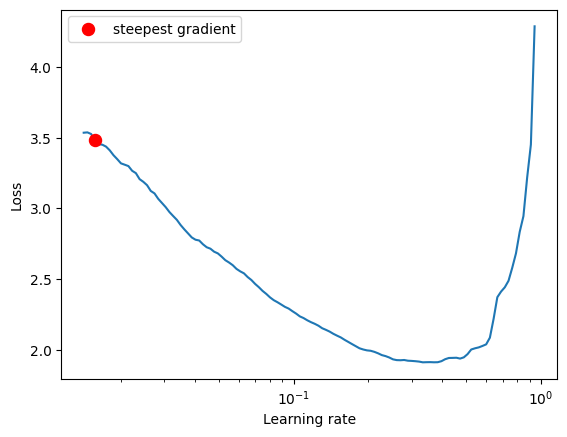

KeyError: ignored

In [4]:
GLOBAL_SEED = 42
seed_everything(GLOBAL_SEED)
params = {}
train_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262), always_apply=True),
    A.transforms.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
    AA.crops.transforms.RandomCrop(height=32, width=32, always_apply=True),
    A.HorizontalFlip(),
    AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1,
                                            max_height=8,
                                            max_width=8,
                                            min_holes = 1,
                                            min_height=8,
                                            min_width=8,
                                            fill_value=(0.491, 0.482, 0.447),
                                            mask_fill_value = None),
    ToTensorV2()])
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262), always_apply=True),
    ToTensorV2(),])
val_transforms = test_transforms

params['train_transforms'] = train_transforms
params['val_transforms'] = val_transforms
params['test_transforms'] = test_transforms
params['val_split'] = 0.1
params['batch_size'] = 512 if torch.cuda.is_available() else 64
params['data_dir'] = os.environ.get("PATH_DATASETS", ".")
params['save_dir'] = "logs/"
# Define data module
cifar10_dm = build_data_module(params)

params['base_lr'] = 0.01
params['base_channels'] = 3
params['num_classes'] = 10
params['drop_out_probability'] = 0.1
params['loss_func'] = F.nll_loss
params['num_workers'] = 2
params['num_epochs'] = 24
params['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_params = {
    'weight_decay': 1e-4,
    'lr': 0.01,
    'momentum': 0.9
}
params['optimizer_type'] = 'Adam'
params['optimizer_params'] = optimizer_params
max_lr = get_max_lr(params, cifar10_dm)


In [5]:
steps_per_epoch = len(cifar10_dm.train_dataset) // params['batch_size']
scheduler_params = {
    'max_lr': max_lr,
    'num_steps_per_epoch': steps_per_epoch,
    'epochs': params['num_epochs'],
    'pct_start': 5./params['num_epochs'],
    'div_factor': 2000,
    'three_phase': False,
    'final_div_factor':1,
    'anneal_strategy':'linear',
}
params['scheduler_type'] = 'OneCycleLR'
params['scheduler_params'] = scheduler_params

# Define model
resnet_model = define_pl_model_resnet(params)

# train and eval model
trainer = train_and_eval_pl_model(params, resnet_model, cifar10_dm)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | CustomResnet | 6.6 M 
---------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.292    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/content/dl_hub/models/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2088` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9315000176429749     │
│         test_loss         │    0.20572128891944885    │
└───────────────────────────┴───────────────────────────┘

,lr-Adam,train_loss,train_acc,val_loss,val_acc,test_loss,test_acc
step,,,,,,,
0,0.000008,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,3.071488,0.128906,NaN,NaN,NaN,NaN
1,0.000044,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,3.008905,0.138672,NaN,NaN,NaN,NaN
2,0.000080,NaN,NaN,NaN,NaN,NaN,NaN


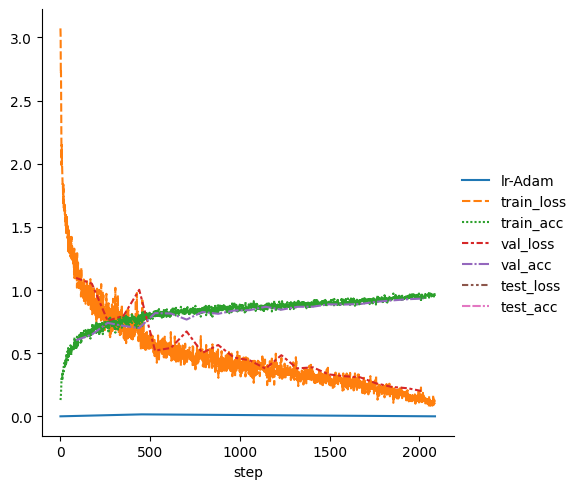

In [15]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"/content/logs/lightning_logs/version_0/metrics.csv")
del metrics["epoch"]
metrics.set_index("step", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")


In [17]:
class_names = {"0": "airplane",
               "1": "automobile",
               "2": "bird",
               "3": "cat",
               "4": "deer",
               "5": "dog",
               "6": "frog",
               "7": "horse",
               "8": "ship",
               "9": "truck"}
num_rows = 5
num_cols = 5
incorrect_predictions = get_incorrect_predictions(resnet_model, cifar10_dm.test_loader, device)
show_incorrect_predictions(incorrect_predictions, class_names, num_rows, num_cols)

NameError: ignored